In [1]:
# import common libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [8]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
# Too many missing values (and to keep things simple)
train = train.drop(columns=['keyword','location'])
test = test.drop(columns=['keyword','location'])

# set index
train = train.set_index('id')
test = test.set_index('id')

In [11]:
train.head()

,text,target
id,,
1,Our Deeds are the Reason of this #earthquake M...,1
4,Forest fire near La Ronge Sask. Canada,1
5,All residents asked to 'shelter in place' are ...,1
6,"13,000 people receive #wildfires evacuation or...",1
7,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
test.head()

,text
id,
0,Just happened a terrible car crash
2,"Heard about #earthquake is different cities, s..."
3,"there is a forest fire at spot pond, geese are..."
9,Apocalypse lighting. #Spokane #wildfires
11,Typhoon Soudelor kills 28 in China and Taiwan


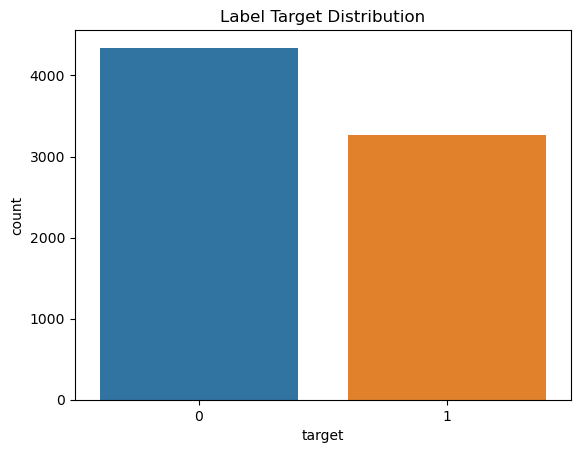

In [18]:
sns.countplot(x='target', data=train,)
plt.title('Label Target Distribution')
plt.show()

In [19]:
# import word tokenizers
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
nltk.download('punkt')
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
print(english_stopwords)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off

In [21]:
#Stemming
def tokenize(text):
    stemmer = SnowballStemmer(language = 'english')
    ret = []
    for token in word_tokenize(text):
        if token.isalpha():
            ret += stemmer.stem(token)
    return ret

In [32]:
#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train['text'])
y_train = train['target']
X_test = vectorizer.transform(test['text'])

In [36]:
print(type(X_train))

<class 'scipy.sparse.csr.csr_matrix'>


In [34]:
#Splitting train data into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(4872, 21637) (1218, 21637) (4872,) (1218,)


In [37]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [40]:
# evaluate
from sklearn.metrics import accuracy_score
y_pred_val = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
print('Validation accuracy:', val_accuracy)

Validation accuracy: 0.7947454844006568


In [45]:
y_pred_test = model.predict(X_test)
submission = pd.DataFrame({'id': test.index, 'target': y_pred_test})
submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [46]:
# submission.to_csv('submission.csv', index=False)

In [48]:
import tensorflow_hub as hub
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

In [56]:
# import BERT tokenization


In [57]:
import tokenization

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

ModuleNotFoundError: No module named 'tokenization'